### Accuracy of positions from accelerometer sensors, the necessity of virtual experiments with sensors

We begin with one dimensional 
synthetic position data recorded at 0.1milisecond intervals
describing the motion of an object at rest to a position 0.14m 
along the X-axis and back again within a 2 second burst.  

The position data is smooth and fine enough to derive 
velocity and acceleration graphs from it (max velocity is 
0.40m/s and max acceleration is 2.78m/s^2).

We conduct a variety of simulated sampling rates on this 
derived acceleration data and then apply noise and limited 
precision to the numbers before attempting to reconstruct 
the velocity and position of the object from this realistic data.

By running simulations of measurements against the synthetic 
data many times under different conditions (eg sampling phase 
and noise) we create a baseline for the statistical 
accuracy based the properties of the sensor.  

This method of simulating the proposed sensors against 
a set of synthetic data provides for a more systematic 
and informed deployment of sensors and 
interprative algorithms in any motion capture 
experiment.

It should be standard practice to have realistic synthetic 
data -- at a far higher resolution that could ever be captured 
in the real world -- as a base line stimulus for these 
virtual experiments.  This must an integral step in the design, 
before any hardware is commissioned or fitted to an 
experimental subject, and it would avoid researchers getting 
ahead of themselves just to collect some numerical data 
which turned out not to be useful.  

There are advantages to establishing a critical eye 
on the potential data before there has been an 
investment in collecting it, as negative comments about it 
afterward the work has been done tends to offend.






### Outline
The synthetic data is loaded and plotted.  
Then the accelerometer data is subsampled to 50ms and 
numerous trajectories of position (graphed against time) 
are reconstructed and plotted on top of one another.

Also pin down tail to constant velocity and measure 
peak height, if this is the data that is required 
(not necessarily the absolute position at any time).
The distribution of errors are shown as a histogram, 
and then later as boxplots.

Suppose we want to estimate the max height and 
can assume that the endpoint velocity and position 
are zero.  Can we use this additional information 
to correct the accelerometer drift and produce a 
tighter estimate?  (Counterintuitively, it turns out 
that it can make the estimate worse.)

In [138]:
from matplotlib import pyplot as plt
%matplotlib inline

In [139]:
import pandas, numpy
from syntheticdata import px

px["v"] = (px.x.diff()/px.t.diff()).shift(-1)
px["a"] = (px.v.diff()/px.t.diff()).shift(-1)
px = px.dropna()
px.head()

,t,x,v,a
0,0.0000,-5.625416e-18,1.125083e-13,-1.687625e-09
1,0.0001,5.625416e-18,-5.625416e-14,2.250166e-09
2,0.0002,0.000000e+00,1.687625e-13,-3.937791e-09
3,0.0003,1.687625e-17,-2.250166e-13,-1.514613e-24
4,0.0004,-5.625416e-18,-2.250166e-13,6.750499e-09


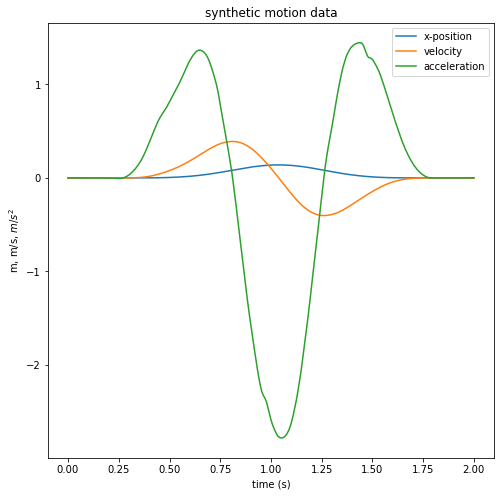

In [141]:
# derive velocity and acceleration from synthetic data

plt.figure(figsize=(8,8), facecolor="white")
plt.plot(px.t, px.x, label="x-position")
plt.plot(px.t, px.v, label="velocity")
plt.plot(px.t, px.a, label="acceleration")
plt.xlabel("time (s)")
plt.ylabel("m, m/s, $m/s^2$")
plt.title("synthetic motion data")
plt.legend();


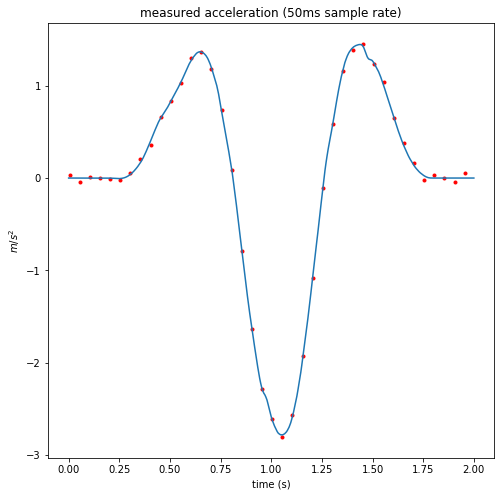

In [142]:
# This gets a series of acceleration samples from the motion at a precision
# acceleration is in m/s^2.  The BNO055 accelerometer measures to 0.01m/s^2
import random
def samplecurve(subsamplerate, startsample, noisestd, precision):
    spx = px.iloc[list(range(startsample, len(px), subsamplerate))]
    ts = list(spx.t)
    accs = [ round(random.gauss(a, noisestd)/precision)*precision  for a in spx.a ]
    return pandas.DataFrame({"t":ts, "a":accs})

plt.figure(figsize=(8,8), facecolor="white")
subsamplerate = 500
sacc = samplecurve(subsamplerate=subsamplerate, startsample=45, noisestd=0.02, precision=0.01)
plt.plot(px.t, px.a)
plt.scatter(sacc.t, sacc.a, marker=".", color="r")
plt.xlabel("time (s)")
plt.ylabel("$m/s^2$")
plt.title("measured acceleration (%dms sample rate)" % int(0.1*subsamplerate));

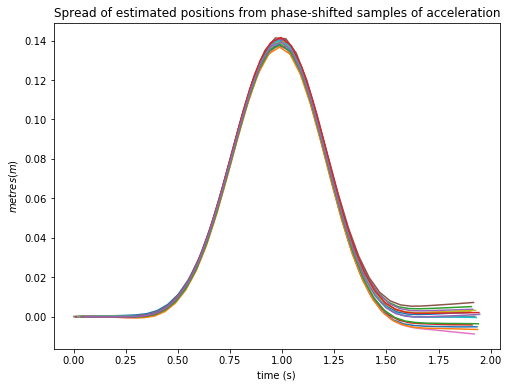

In [143]:
# Now consider the same data but with many different 
# sampling phases with sensor noise added
plt.figure(figsize=(8,6), facecolor="white")
subsamplerate = 500
for startsample in range(10, subsamplerate, 33):
    sacc = samplecurve(subsamplerate=subsamplerate, startsample=startsample, noisestd=0.02, precision=0.01)
    sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
    sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
    plt.plot(sacc.t, sacc.x)
plt.title("Spread of estimated positions from phase-shifted samples of acceleration")
plt.xlabel("time (s)")
plt.ylabel("$metres (m)$")
None

Mean -0.0010494 std 0.0179058320706


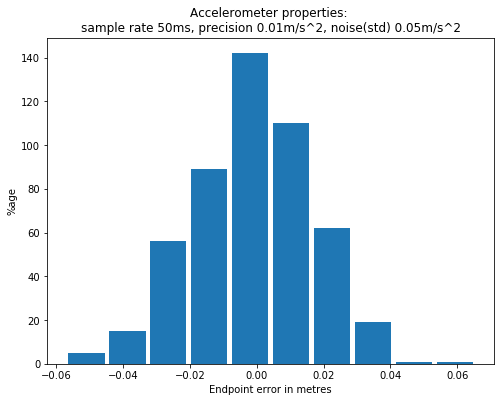

In [144]:
plt.figure(figsize=(8,6), facecolor="white")
subsamplerate = 500
noisestd = 0.05
precision = 0.01
def getxends(subsamplerate, noisestd, precision, nsamples):
    xends = [ ]
    for startsample in numpy.random.uniform(0, subsamplerate, nsamples):
        sacc = samplecurve(subsamplerate=subsamplerate, startsample=int(startsample), noisestd=noisestd, precision=precision)
        sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
        sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
        xends.append(sacc.x.iloc[-2])
    return numpy.array(xends)
    
xends = getxends(subsamplerate, noisestd, precision, 500)
plt.hist(xends, rwidth=0.9)
plt.title("Accelerometer properties: \nsample rate %dms, precision %.02fm/s^2, noise(std) %0.02fm/s^2" % (int(0.1*subsamplerate), precision, noisestd))
plt.ylabel("%age")
plt.xlabel("Endpoint error in metres");
print("Mean", xends.mean(), "std", xends.std())

In [145]:
# Generate the lists of errors from different noise
noisestds = numpy.linspace(0, 0.05, 6)
xendsmeans = [ ]
xendsstds = [ ]
nsamples = 100
xendslist = [ ]
for noisestd in noisestds:
    xends = getxends(subsamplerate=500, noisestd=noisestd, precision=0.01, nsamples=nsamples)
    xendslist.append(xends)


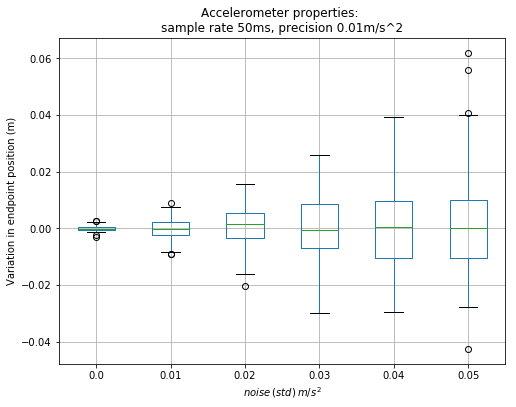

In [146]:
plt.figure(figsize=(8,6), facecolor="white")
df = pandas.DataFrame(data=xendslist).transpose()
df.columns = noisestds
boxplot = df.boxplot()
plt.xlabel("$noise\\:(std)\\:m/s^2$")  # latex mode for ^2 (square) symbol
plt.ylabel("Variation in endpoint position (m)")
plt.title("Accelerometer properties: \nsample rate %dms, precision %.02fm/s^2" % (int(0.1*subsamplerate), precision))
None

In [147]:
# Generate the lists of errors from different sample rates
samplemss = numpy.linspace(10, 60, 6)
nsamples = 500
noisestd = 0.05
xendslist = [ ]
for samplems in samplemss:
    xends = getxends(subsamplerate=int(samplems/0.1), noisestd=noisestd, precision=0.01, nsamples=nsamples)
    xendslist.append(xends)


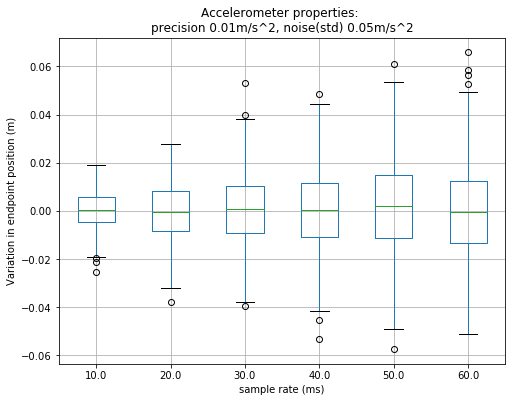

In [148]:
plt.figure(figsize=(8,6), facecolor="white")
df = pandas.DataFrame(data=xendslist).transpose()
df.columns = samplemss
boxplot = df.boxplot()
plt.xlabel("sample rate (ms)")
plt.ylabel("Variation in endpoint position (m)")
plt.title("Accelerometer properties: \nprecision %.02fm/s^2, noise(std) %0.02fm/s^2" % (0.01, noisestd))
None

### End point corrections

While we have to assume we are starting at x=0 with a stationary 
velocity, it can be fair to assume that the ending point 
has a stationary velocity and correct for drift (cumulative 
acceleration errors that should sum to zero).  

Sometimes on level ground we can assume that the 
endpoint position is also at zero.

In these cases we are estimating the maximum distance 
during the traversal.

The conclusions of this test are surprising.

In [ ]:
# Now consider the same data but with many different 
# sampling phases with sensor noise added
subsamplerate = 500
noisestd = 0.05
precision = 0.1
startsample = 33
sacc = samplecurve(subsamplerate=subsamplerate, startsample=startsample, noisestd=noisestd, precision=precision)

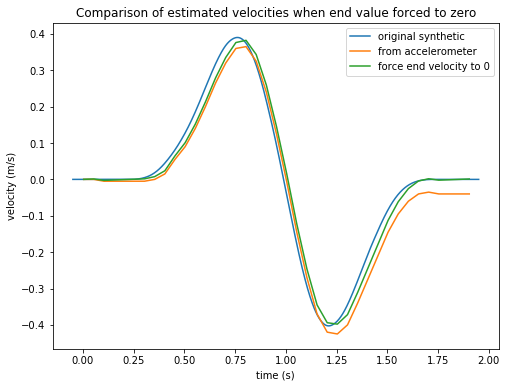

In [198]:
plt.figure(figsize=(8,6), facecolor="white")

vend = sacc["v"].iloc[-3]  # avoid the nans
tend = sacc["t"].iloc[-3]
sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
sacc["vfixed"] = sacc["v"] - vend*(sacc["t"]/tend)

plt.plot(px.t-0.05, px.v, label="original synthetic")
plt.plot(sacc.t, sacc.v, label="from accelerometer")
plt.plot(sacc.t, sacc.vfixed, label="force end velocity to 0")

plt.title("Comparison of estimated velocities when end value forced to zero")
plt.xlabel("time (s)")
plt.ylabel("velocity (m/s)")
plt.legend()
None


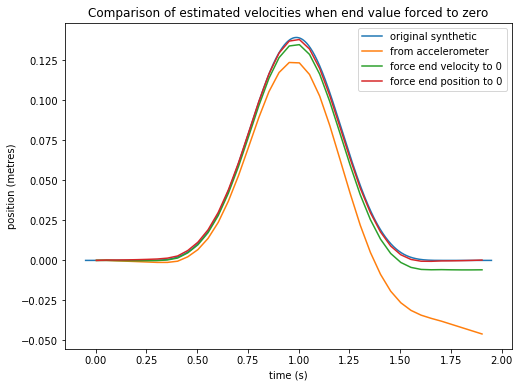

In [199]:
plt.figure(figsize=(8,6), facecolor="white")

sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
vend = sacc["v"].iloc[-3]  # avoid the nans
tend = sacc["t"].iloc[-3]
sacc["vfixed"] = sacc["v"] - vend*(sacc["t"]/tend)

sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
sacc["xvfixed"] = (sacc.vfixed*sacc.t.diff().shift(-1)).cumsum()
xend = sacc["xvfixed"].iloc[-3]  # avoid the nans
sacc["xfixed"] = sacc["xvfixed"] - xend*(sacc["t"]/tend)

plt.plot(px.t-0.05, px.x, label="original synthetic")
plt.plot(sacc.t, sacc.x, label="from accelerometer")
plt.plot(sacc.t, sacc.xvfixed, label="force end velocity to 0")
plt.plot(sacc.t, sacc.xfixed, label="force end position to 0")

plt.title("Comparison of estimated velocities when end value forced to zero")
plt.xlabel("time (s)")
plt.ylabel("position (metres)")
plt.legend()
None


**Note** We had to run the above example several times to 
make an illustration that fits with the intuition 
of fixing the end points improving the mid-point estimate.

This trickery was found out when we tried to prove this 
effect using the output of numerous runs in our virtual 
experiment.

In [209]:
# Now consider the same data but with many different 
# sampling phases with sensor noise added
subsamplerate = 500
noisestd = 0.05
precision = 0.1
startsample = 33

peakx = [ ]
peakxvfixed = [ ]
peakxfixed = [ ]
for startsample in range(10, subsamplerate, 5):
    sacc = samplecurve(subsamplerate=subsamplerate, startsample=startsample, noisestd=noisestd, precision=precision)
    sacc["v"] = (sacc.a*sacc.t.diff().shift(-1)).cumsum()
    sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
    sacc["vfixed"] = sacc["v"] - vend*(sacc["t"]/tend)
    vend = sacc["v"].iloc[-3]  # avoid the nans
    tend = sacc["t"].iloc[-3]

    sacc["x"] = (sacc.v*sacc.t.diff().shift(-1)).cumsum()
    sacc["xvfixed"] = (sacc.vfixed*sacc.t.diff().shift(-1)).cumsum()
    xend = sacc["xvfixed"].iloc[-3]  # avoid the nans
    sacc["xfixed"] = sacc["xvfixed"] - xend*(sacc["t"]/tend)
    peakx.append(max(sacc["x"]))
    peakxvfixed.append(max(sacc["xvfixed"]))
    peakxfixed.append(max(sacc["xfixed"]))


True value is 0.139394535746


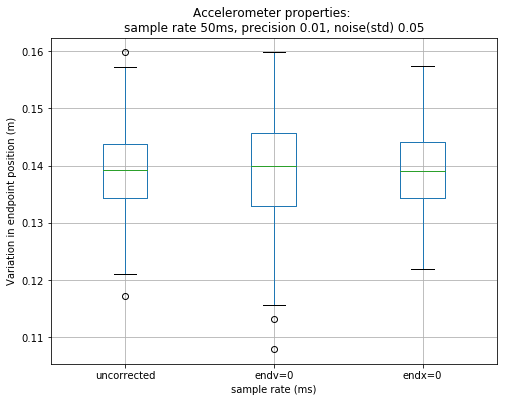

In [216]:
plt.figure(figsize=(8,6), facecolor="white")
df = pandas.DataFrame(data=[peakx,peakxvfixed,peakxfixed]).transpose()
df.columns = ["uncorrected", "endv=0", "endx=0"]
boxplot = df.boxplot()
plt.xlabel("sample rate (ms)")
plt.ylabel("Variation in endpoint position (m)")
plt.title("Accelerometer properties: \nsample rate %dms, precision %.02f, noise(std) %0.02f" % (int(subsamplerate*0.1), 0.01, noisestd))
print("True value is", max(px.x))

It turns out that forcing the end point to have zero 
velocity and/or zero position and interpolating this 
correction back through the positions makes the 
estimate of the peak height no better.

This is because the peak is attained when only half the 
data has been interpolated (ie after 1 second of motion), 
so the error is going to be half that of the error 
at the endpoint (at the 2 second point).  

The process of forcing the endpoint to zero re-distributes 
the errors from the second half of the data back across the 
whole range which compromises any improvement made due to 
this correction.

